In [69]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import scaling

from xarray.ufuncs import cos, deg2rad
from scipy.ndimage import gaussian_filter


In [70]:
#WRF preprocessing
#SCRATCH = "/global/cscratch1/sd/qnicolas/"
#wrfout = Dataset(os.path.join(SCRATCH,"wrfout/wrfout_d01_0001-01-01_00:00:00"))
#
#vardict = {}
#vars = ["slp","lat","lon","ua","va","omega","pressure","tk","z","ter"]
#
#t=time.time()
#for var in vars:
#    vardict[var] = wrf.getvar(wrfout, var, wrf.ALL_TIMES)
#print(time.time()-t)

#120.7 seconds


In [71]:
def scaling3(omega, temp, ps, levels):
    """Same as "scaling", but the arguments are sorted by increasing pressure and plevs are already input.
    scaling3 is to be vectorized by xarray"""
    
    return scaling(omega[::-1], temp[::-1], levels[::-1], ps)

In [72]:
HOME = "/global/homes/q/qnicolas/"
allvars = xr.open_dataset(HOME+"WRF/processed/wrf.mountain.100km.sfc.nc",use_cftime=True)
allvars['time'] = (allvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()
allplvars = xr.open_dataset(HOME+"WRF/processed/wrf.mountain.100km.pl.nc",use_cftime=True) #Took 25min to produce with wrfoutocf
allplvars['time'] = (allplvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()
allplvars=allplvars.rename({'pressure':'level'})#.isel(pressure=range(1,len(np.array(allplvars.pressure))))
#allvars = allvars.assign_coords({'south_north' : np.arange(0.,70.,1.),'west_east' : np.arange(0.,80.,1.)})

# Precip maps

In [73]:
all_precip_g = allvars.precip_g.isel(time=range(100,401)).diff('time').assign_coords(time = allvars.precip_g.time.isel(time=range(100,400)))
all_precip_c = allvars.precip_c.isel(time=range(100,401)).diff('time').assign_coords(time = allvars.precip_g.time.isel(time=range(100,400)))

daily_precip_g = all_precip_g.resample(time='1D').sum()
daily_precip_c = all_precip_c.resample(time='1D').sum()

daily_precip = daily_precip_g + daily_precip_c

mean_precip_g = daily_precip_g.mean("time")
mean_precip_c = daily_precip_c.mean("time")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


Text(0.5, 1.0, 'Convective precip')

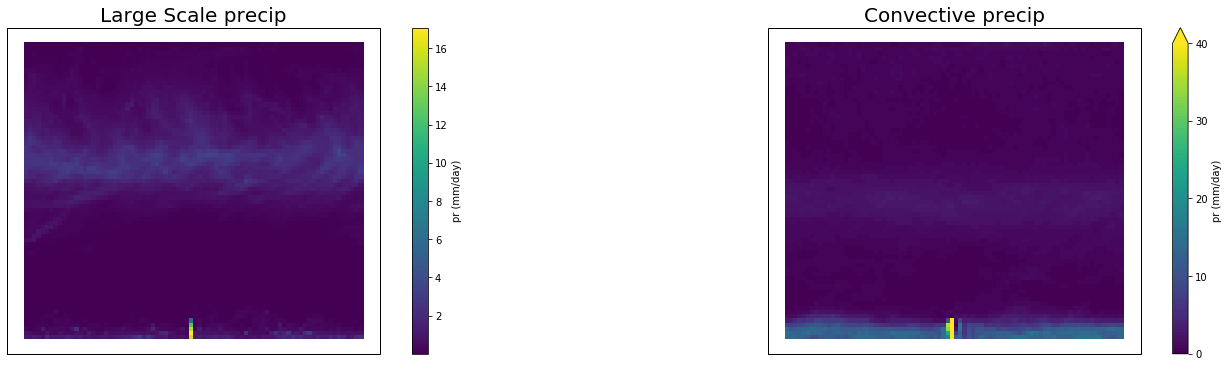

In [74]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})

mean_precip_g.plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(0,40.,100))
mean_precip_c.plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,41.,10.)},levels=np.linspace(0,40.,100))
ax1.set_title("Large Scale precip",fontsize=20)
ax2.set_title("Convective precip" ,fontsize=20)

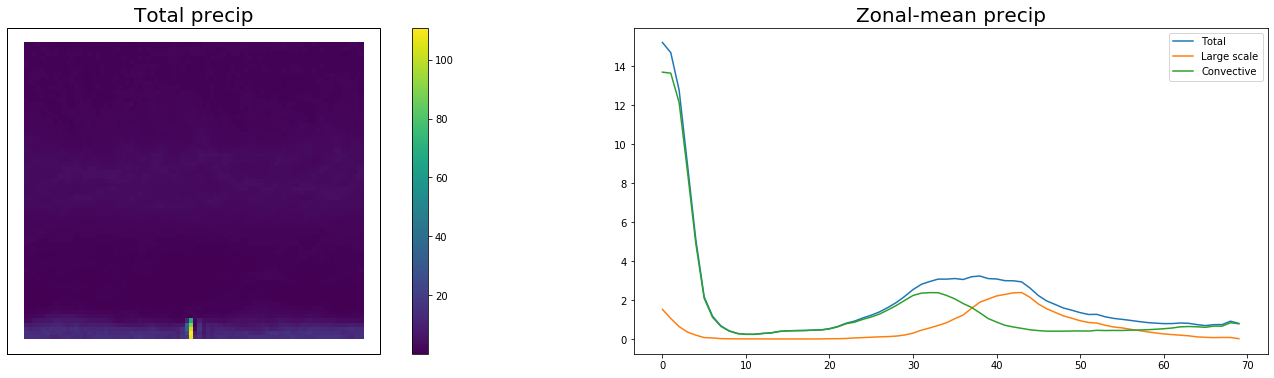

In [75]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(121,projection =  ccrs.PlateCarree())
(mean_precip_g+mean_precip_c).plot(ax=ax1,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"w_upslope (m/s)","ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(-0.02,0.02,100))
ax2 = fig.add_subplot(122)
plt.plot(mean_precip_g.south_north,(mean_precip_g+mean_precip_c).mean("west_east"),label="Total")
plt.plot(mean_precip_g.south_north,(mean_precip_g).mean("west_east"),label="Large scale")
plt.plot(mean_precip_g.south_north,(mean_precip_c).mean("west_east"),label="Convective")


ax1.set_title("Total precip",fontsize=20)
ax2.set_title("Zonal-mean precip",fontsize=20)
plt.legend()

# Precip extremes

(array([ 2.,  1.,  3.,  5.,  9.,  8.,  8., 10.,  7.,  6.,  9.,  2.,  3.,
         0.,  2.]),
 array([ 23.164076,  28.296595,  33.429115,  38.561634,  43.694153,
         48.82667 ,  53.95919 ,  59.09171 ,  64.22423 ,  69.35675 ,
         74.489265,  79.62179 ,  84.7543  ,  89.886826,  95.01934 ,
        100.15186 ], dtype=float32),
 <a list of 15 Patch objects>)

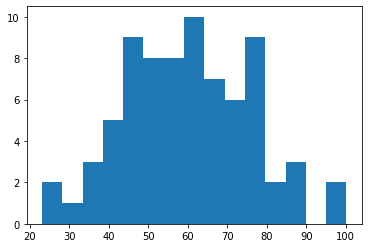

In [76]:
precip_mountain = (daily_precip_g+daily_precip_c).isel(west_east = range(38,40),south_north = range(5)).mean(["west_east","south_north"])
plt.hist(precip_mountain, bins = 15, label="distribution of daily precip")


In [77]:
p95 = precip_mountain.where(precip_mountain>float(precip_mountain.quantile(0.95,"time")),drop=True)
p95_times = [pd.to_datetime(d+' {:0>2}'.format(h)) for d in list(pd.to_datetime(np.array(p95.time)).strftime("%Y-%m-%d")) for h in range(0,24,6)]

In [78]:
t2_p95 = 273.15+allvars.T_2m.sel(time=p95_times)
ps_p95 = allvars.p_sfc.sel(time=p95_times)
Z_sfc = allvars.Z_sfc

u10_p95 = allvars.u_10m_gr.sel(time=p95_times)
v10_p95 = allvars.u_10m_gr.sel(time=p95_times) 

m_per_gridbox = 100e3

ddxorog = Z_sfc.differentiate("west_east")/m_per_gridbox
ddyorog = Z_sfc.differentiate("south_north")/m_per_gridbox

pr_roe_p95 = np.maximum(86400*1.2*qsat(t2_p95,ps_p95)*(u10_p95*ddxorog+v10_p95*ddyorog),0.)
pr_roe_mountain_p95 = pr_roe_95.isel(west_east = range(38,40),south_north = range(5)).resample(time='1D').mean(["time","west_east","south_north"]).sel(time=p95.time)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


In [79]:
pr_roe_mountain_p95

<xarray.DataArray (time: 4)>
array([20.491713, 23.362778, 11.011537, 22.258541], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1970-02-05 1970-02-06 1970-03-08 1970-03-28

In [80]:
precip_g_mountain = daily_precip_g.isel(west_east = range(38,40),south_north = range(5)).mean(["west_east","south_north"])
precip_g_mountain_p95 = precip_g_mountain.sel(time=p95.time)
precip_g_mountain_p95

<xarray.DataArray 'precip_g' (time: 4)>
array([ 9.036656, 32.5764  , 25.133013, 43.55402 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1970-02-05 1970-02-06 1970-03-08 1970-03-28

In [81]:
t_p95 = allplvars.T_p.sel(time=p95_times)
u_p95 = allplvars.u_gr_p.sel(time=p95_times)
v_p95 = allplvars.v_gr_p.sel(time=p95_times)
w_p95 = allplvars.w_p.sel(time=p95_times)
ref_density = t_p95.level*100/(287*t_p95.mean(["time","west_east","south_north"]))

omega_p95 = upslope_omega_sin(ps_p95*100,u_p95*ddxorog+v_p95*ddyorog)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [82]:
t_p95=t_p95.where(~np.isnan(t_p95),300)
pr_og_sin_p95 = 86400*xr.apply_ufunc(scaling3,
                               omega_p95.isel(west_east = range(38,40),south_north = range(5)),
                               t_p95.isel(west_east = range(38,40),south_north = range(5)),
                               100*ps_p95.isel(west_east = range(38,40),south_north = range(5)),
                               100*omega_p95.level,
                               input_core_dims=[['level'], ['level'],[],['level']],vectorize=True)

pr_og_p95 = 86400*xr.apply_ufunc(scaling3,
                               -ref_density*9.81*w_p95.isel(west_east = range(38,40),south_north = range(5)),
                               t_p95.isel(west_east = range(38,40),south_north = range(5)),
                               100*ps_p95.isel(west_east = range(38,40),south_north = range(5)),
                               100*w_p95.level,
                               input_core_dims=[['level'], ['level'],[],['level']],vectorize=True)

pr_og_sin_p95_mountain = pr_og_sin_p95.resample(time='1D').mean(["time","west_east","south_north"]).sel(time=p95.time)
pr_og_p95_mountain = pr_og_p95.resample(time='1D').mean(["time","west_east","south_north"]).sel(time=p95.time)



/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


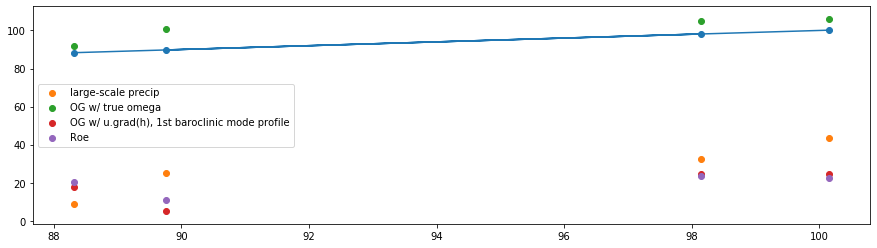

In [83]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(p95,p95                   )
ax.scatter(p95,p95                   )
ax.scatter(p95,precip_g_mountain_p95 ,label="large-scale precip")
ax.scatter(p95,pr_og_p95_mountain    ,label="OG w/ true omega")
ax.scatter(p95,pr_og_sin_p95_mountain,label="OG w/ u.grad(h), 1st baroclinic mode profile")
ax.scatter(p95,pr_roe_mountain_p95   ,label="Roe")
ax.legend()

In [84]:
pr_og_sin_p95_mountain

<xarray.DataArray (time: 4)>
array([17.6534245 , 24.70694018,  5.08307618, 24.65091592])
Coordinates:
  * time     (time) datetime64[ns] 1970-02-05 1970-02-06 1970-03-08 1970-03-28

# Composites on extreme events

In [85]:
Z_composite = allplvars.Z_p.sel(  time=p95_times,level=850.).mean('time')
pv_composite = allplvars.pvo_p.sel(time=p95_times,level=850.).mean('time')

Text(0.5, 1.0, '850hPa PV composite, 95th percentile extreme events')

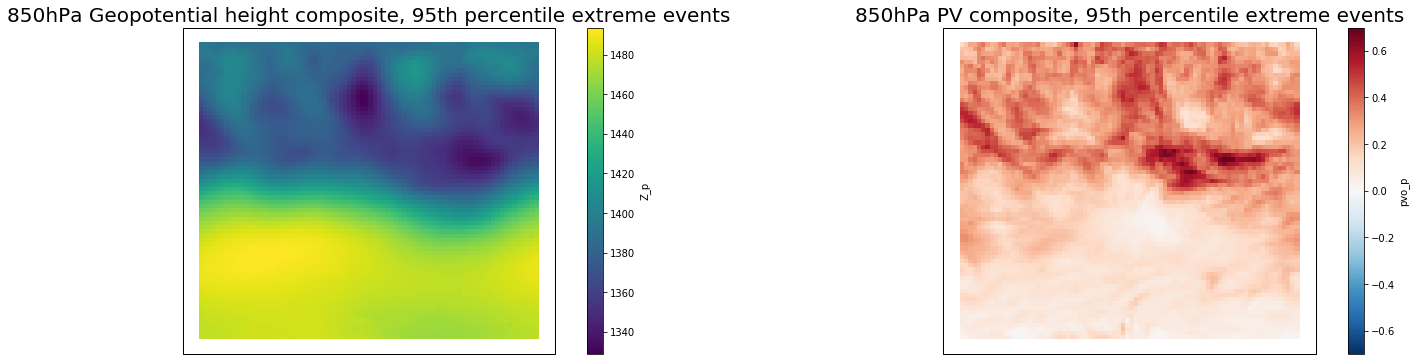

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})

Z_composite.plot(ax=ax1,transform=ccrs.PlateCarree() )#,cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(0,40.,100))
pv_composite.plot(ax=ax2,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,41.,10.)},levels=np.linspace(0,40.,100))
ax1.set_title("850hPa Geopotential height composite, 95th percentile extreme events",fontsize=20)
ax2.set_title("850hPa PV composite, 95th percentile extreme events" ,fontsize=20)

# Mountain vs Aquaplanet

In [87]:
aquasfcvars = xr.open_dataset(HOME+"WRF/processed/wrf.aquaplanet.100km.sfc.nc",use_cftime=True)
aquasfcvars['time'] = (aquasfcvars.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()



In [88]:
aqua_precip_g = aquasfcvars.precip_g.isel(time=range(100,401)).diff('time').assign_coords(time = aquasfcvars.precip_g.time.isel(time=range(100,400)))
aqua_precip_c = aquasfcvars.precip_c.isel(time=range(100,401)).diff('time').assign_coords(time = aquasfcvars.precip_c.time.isel(time=range(100,400)))

daily_aqua_precip_g = aqua_precip_g.resample(time='1D').sum()
daily_aqua_precip_c = aqua_precip_c.resample(time='1D').sum()

daily_aqua_precip = daily_aqua_precip_c+daily_aqua_precip_g

mean_aqua_precip_g = daily_aqua_precip_g.mean("time")
mean_aqua_precip_c = daily_aqua_precip_c.mean("time")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


## Mean precip

Text(0.5, 1.0, 'Mean total precip, aquaplanet')

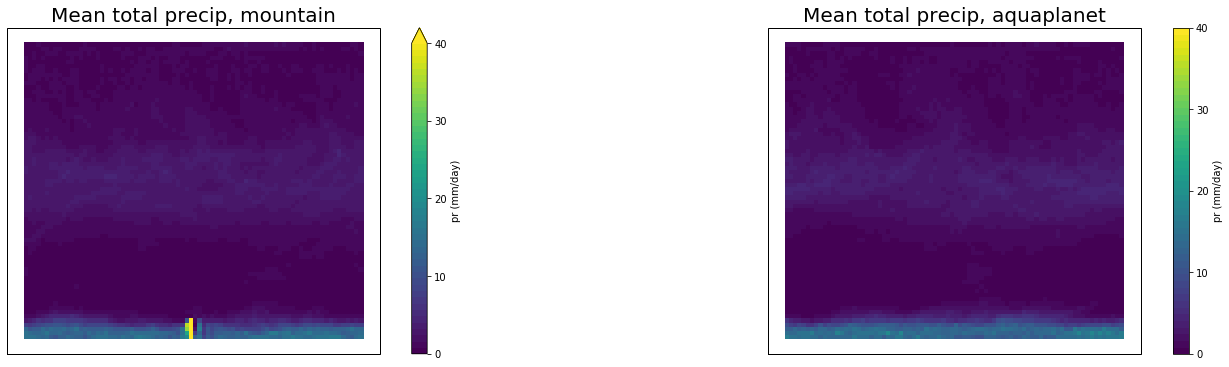

In [89]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(121,projection =  ccrs.PlateCarree())
(mean_precip_g+mean_precip_c).plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,41.,10.)},levels=np.linspace(0.,40.,50))
ax2 = fig.add_subplot(122,projection =  ccrs.PlateCarree())
(mean_aqua_precip_g+mean_aqua_precip_c).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,41.,10.)},levels=np.linspace(0.,40.,50))


ax1.set_title("Mean total precip, mountain",fontsize=20)
ax2.set_title("Mean total precip, aquaplanet",fontsize=20)

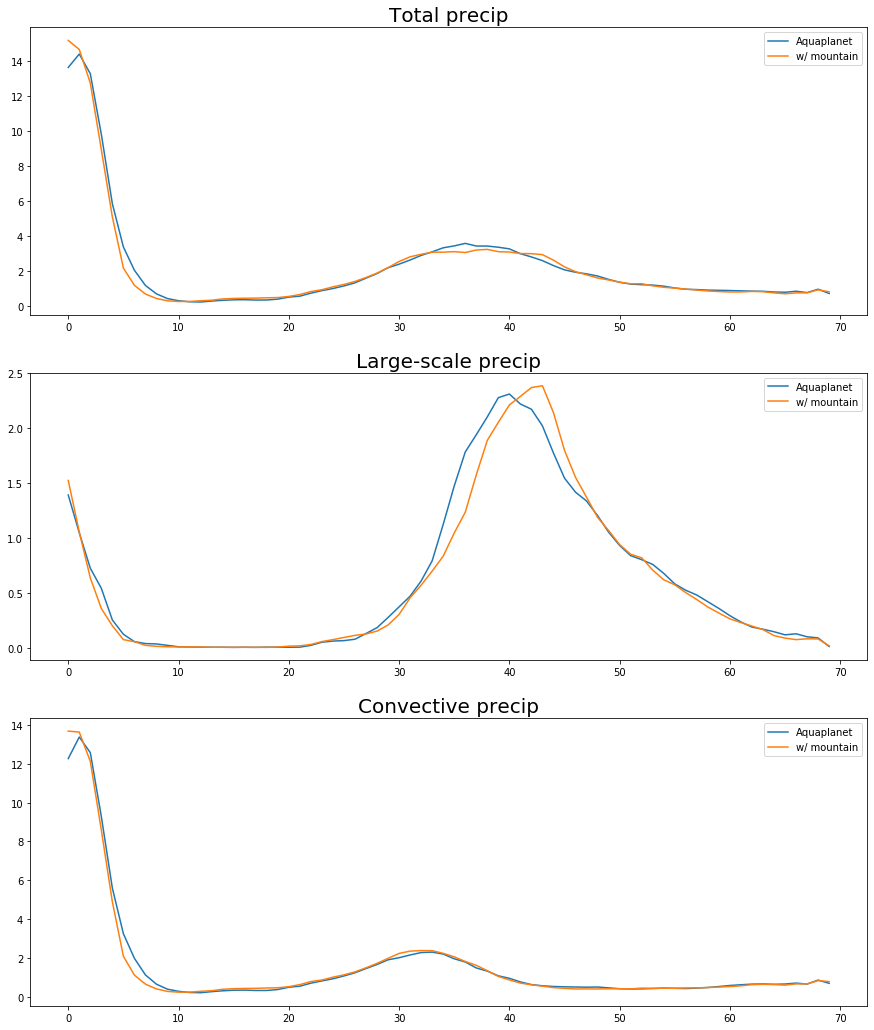

In [90]:
fig, ax = plt.subplots(3,1,figsize=(15,18))

ax[0].plot(mean_aqua_precip_g.south_north,(mean_aqua_precip_g+mean_aqua_precip_c).mean("west_east"),label="Aquaplanet")
ax[1].plot(mean_aqua_precip_g.south_north,(mean_aqua_precip_g).mean("west_east"),                   label="Aquaplanet")
ax[2].plot(mean_aqua_precip_g.south_north,(mean_aqua_precip_c).mean("west_east"),                   label="Aquaplanet")


ax[0].plot(mean_precip_g.south_north,(mean_precip_g+mean_precip_c).mean("west_east"),label="w/ mountain")
ax[1].plot(mean_precip_g.south_north,(mean_precip_g).mean("west_east"),              label="w/ mountain")
ax[2].plot(mean_precip_g.south_north,(mean_precip_c).mean("west_east"),              label="w/ mountain")


ax[0].set_title("Total precip",fontsize=20)
ax[1].set_title("Large-scale precip",fontsize=20)
ax[2].set_title("Convective precip",fontsize=20)
ax[0].legend()
ax[1].legend()
ax[2].legend()

## 95th percentile

In [91]:
#p95_map_mountain = daily_precip.where(daily_precip>float(daily_precip.quantile(0.95,"time")),drop=True)

p95_map_mountain = daily_precip.quantile(0.95,"time")
p95_map_aqua = daily_aqua_precip.quantile(0.95,"time")

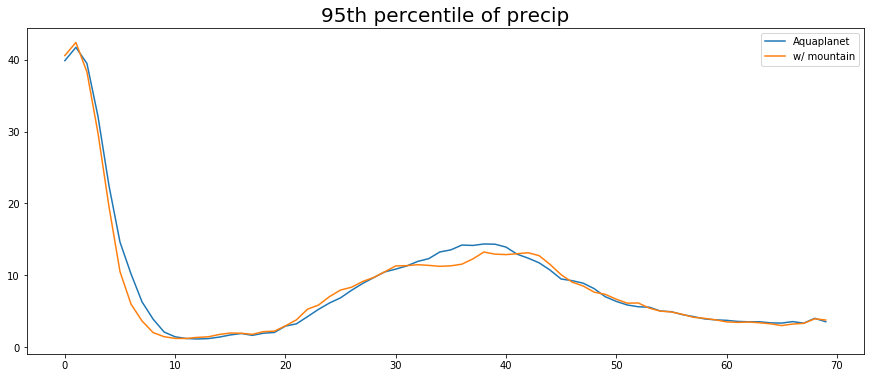

In [92]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

ax.plot(p95_map_aqua.south_north,p95_map_aqua.mean("west_east"),label="Aquaplanet")
ax.plot(p95_map_mountain.south_north,p95_map_mountain.mean("west_east"),label="w/ mountain")


ax.set_title("95th percentile of precip",fontsize=20)
ax.legend()


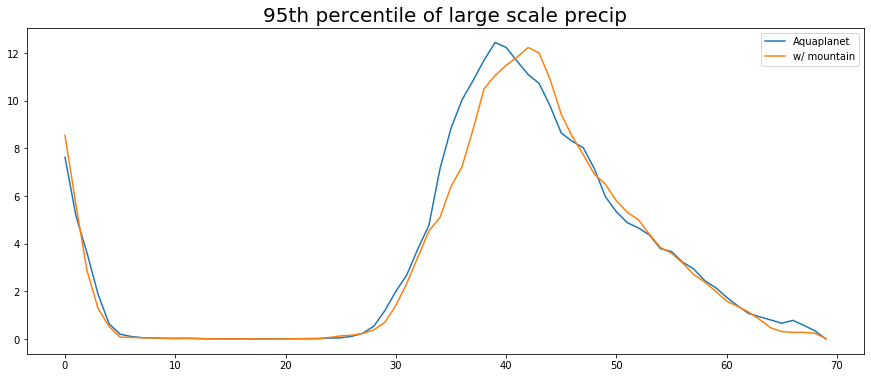

In [93]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

p95_map_mountain_g = daily_precip_g.quantile(0.95,"time")
p95_map_aqua_g = daily_aqua_precip_g.quantile(0.95,"time")

ax.plot(p95_map_aqua_g.south_north,p95_map_aqua_g.mean("west_east"),label="Aquaplanet")
ax.plot(p95_map_mountain_g.south_north,p95_map_mountain_g.mean("west_east"),label="w/ mountain")


ax.set_title("95th percentile of large scale precip",fontsize=20)
ax.legend()


# Insolation

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


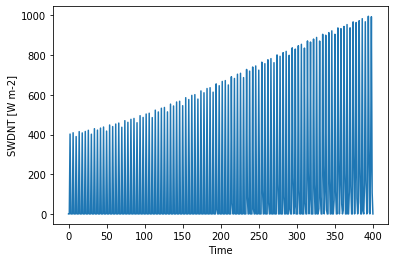

In [95]:
wrfout = xr.open_dataset(HOME+"WRF/saves/wrf.mountain.100km.SST2K.nc_orig")
sw_toa = wrfout.SWDNT

sw_toa.isel(south_north=50,west_east=40).plot()
